# Importing the Libraries

In [4]:
%reload_ext nb_black
"""Main"""
import os
import pickle
import gzip
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 100)

"""Data Visualization"""
import seaborn as sns
color = sns.color_palette()
import matplotlib.pyplot as plt

"""Data Preparation and Model Evaluation"""
from scipy import stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection

"""Machine Learning Alogrithms"""
import xgboost as xgb
import lightgbm as lgb
from sklearn import linear_model
from sklearn import ensemble
print("Libraries Imported!!")

Libraries Imported!!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load the MNIST datasets

In [73]:
with gzip.open("./input/mnist.pkl.gz", "rb") as f:
    train_set, validation_set, test_set = pickle.load(f, encoding="latin1")

In [74]:
X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

# Verify shape of datasets
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_validation: ", X_validation.shape)
print("Shape of y_validation: ", y_validation.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (50000, 784)
Shape of y_train:  (50000,)
Shape of X_validation:  (10000, 784)
Shape of y_validation:  (10000,)
Shape of X_test:  (10000, 784)
Shape of y_test:  (10000,)


In [75]:
X_train = pd.DataFrame(data=X_train)
y_train = pd.Series(y_train)

X_validation =  pd.DataFrame(data=X_validation)
y_validation = pd.Series(y_validation)

X_test = pd.DataFrame(data=X_test)
y_test = pd.Series(y_test)

# Explore the data

In [76]:
X_train.isna().sum().sum()

0

In [77]:
X_train.dtypes

0      float32
1      float32
2      float32
3      float32
4      float32
        ...   
779    float32
780    float32
781    float32
782    float32
783    float32
Length: 784, dtype: object

In [78]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
0,50000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
1,50000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
2,50000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
3,50000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
4,50000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...
779,50000.0,0.000009,0.001483,0.0,0.0,0.0,0.0,0.242188
780,50000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
781,50000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
782,50000.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000


### Display the images

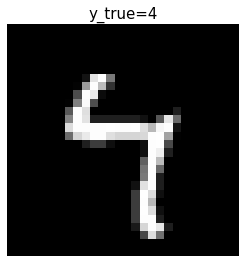

In [100]:
import random
idx = random.randint(0, 1000)

img_array = X_train.loc[idx, :].values
img_label = y_train[idx]

plt.imshow(img_array.reshape(28, -1), cmap="gray")
plt.title(f"y_true={img_label}", fontsize=15)
plt.tight_layout()
plt.axis("off")
plt.show()

# Types of Dimensionality Reduction:
- **1. Linear projection:** 
<br/>
    It involves linearly projecting data from a high-dimensional space to a low-dimensional space. 
    Example: Principal component analysis, Singular value decomposition, and random projection.
- **2. Manifold learning:**
<br/>
    Referred to as nonlinear dimensionality reduction. Example: t-distributed stochastic neighbor embedding (t-SNE)

# 1.1 Principal Component Analysis (PCA)
- Generally we must scale the data to make sure the features are in the same relative range. However, for our MNIST digits dataset, the features are already scaled to a range of zero to one, so we can skip this step.

In [203]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=784, whiten=True, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_train_pca = pd.DataFrame(X_train_pca)

In [129]:
pca.explained_variance_ratio_

(784,)

### Validating the variance covered over the Principal Components

In [155]:
n_components = []
cummulative_variance_explained = []

for n_component in range(0, 784, 10):
    
    variance_explained =  sum(pca.explained_variance_ratio_[:n_component])
    n_components.append(n_component)
    cummulative_variance_explained.append(variance_explained)

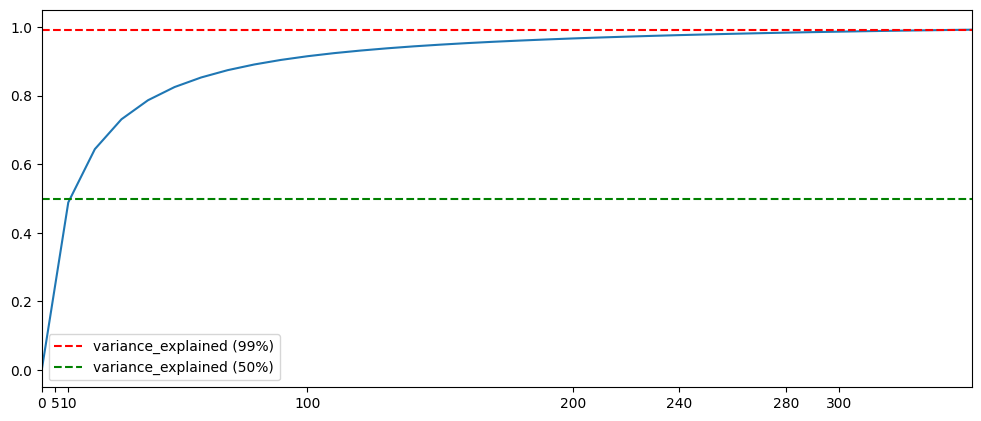

In [204]:
plt.figure(figsize=(12, 5), dpi=100) 
plt.plot(n_components, cummulative_variance_explained)
plt.axhline(y=0.99, color="red", linestyle="--", label="variance_explained (99%)")
plt.axhline(y=0.50, color="green", linestyle="--", label="variance_explained (50%)")
# plt.axvline(x=10, color="k", linestyle="-")
# plt.axvline(x=250, color="k", linestyle="-")
plt.xlim([0, 350])
plt.xticks([0, 5, 10, 100, 200, 240, 280, 300])
plt.legend()
plt.show()

### Conclusion:
- The first 10 components in total capture approximately 50% of the variance.
- the first 100 components over 90%, and 
- the first 300 components almost 99% of the variance,
- *the information in the rest of the principal components is of negligible value.*
----

## Visualize the separation of points in space
Plot the observations in two dimensions. Specifically, we will display a scatterplot of the first and second principal components and mark the observations by the true label.

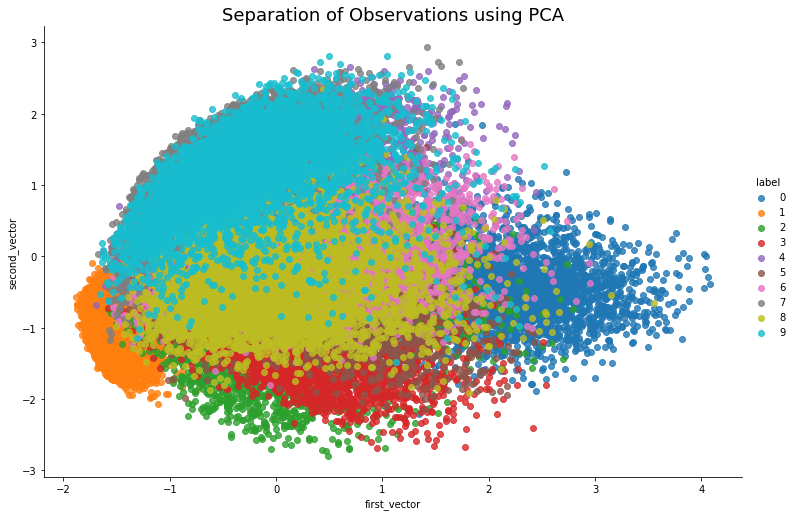

In [284]:

def scatter_plot(df, y_label, algoName, height=7, aspect=1.5):
    
    tempDF = df.loc[:, 0:1]
    tempDF = pd.concat([tempDF, y_label], axis=1)
    tempDF.columns = ["first_vector", "second_vector", "label"]
    
    sns.lmplot(data=tempDF, x="first_vector", y="second_vector", hue="label", scatter=True, fit_reg=False, height=height, aspect=aspect)
    title_ = f"Separation of Observations using {algoName}"
    plt.title(title_, size=18)
    plt.show()
        
scatter_plot(X_train_pca, y_train, "PCA")

# 1.2 Incremental PCA
- For datasets that are very large and cannot fit in memory.
- we can perform PCA incrementally in small batches, where `each batch is able to fit in memory.`

In [263]:
from sklearn.decomposition import IncrementalPCA

n_components = 784
batch_size = None

incrementalPCA = IncrementalPCA(n_components=n_components,
                                batch_size=batch_size)

X_train_incrementalPCA = incrementalPCA.fit_transform(X_train)
X_train_incrementalPCA = pd.DataFrame(X_train_incrementalPCA)

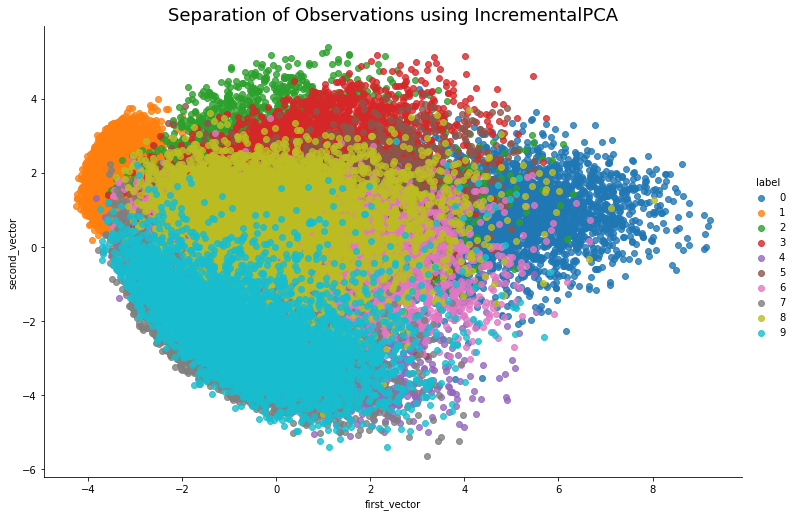

In [274]:
scatter_plot(X_train_incrementalPCA, y_train, "IncrementalPCA", height=7, aspect=1.5)

## 1.3 Kernel PCA

## 2.1 t-distributed stochastic neighbor embedding (t-SNE)